# Sentiment Analysis with
## Word embedding and LSTM

In this exercise, we will build a deep LSTM network and insert a fixed pre-trained embedding layer in Keras

<img src="resources/pipeline.png" width="800px">

## Still Emoji

In [20]:
# import 
import numpy as np
import p3_utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Embedding
from tensorflow.keras.preprocessing import sequence

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'


np.random.seed(1)

In [21]:
train_x, test_x, train_y, test_y = p3_utils.load_emoji()

In [22]:
for i in range(10):
    print(train_x[i], train_y[i])

never talk to me again 3
I am proud of your achievements 2
It is the worst day in my life 3
Miss you so much 0
food is life 4
I love you mum 0
Stop saying bullshit 3
congratulations on your acceptance 2
The assignment is too long  3
I want to go play 1


**Load pretrained word embeddings**

2 dictionaries are loaded:

- `word_to_index`: map a word to its index in the vocabulary
    - Example:  `'word' -> 1234`

- `word_to_vec_map`: map a word to its embedding
    - Example: `'word' -> [0.1, 0.2, ..., 0.45]`

When adding a custom embedding layer in Keras, we can only load the pretrained embedding as a big matrix instead of a dictionary. An index will help us locate the entry for a given word.

### Word Embeddings & One Hot

In [23]:
word_to_index, word_to_vec_map = p3_utils.load_glove_vecs()

data already available, skip downloading.
loading glove... this may take a while...
glove loaded successfully.


In [24]:
p3_utils.sentences_to_indices?

In [25]:
# Convert word to the index in vocabulary
p3_utils.sentences_to_indices(
    np.array(["i like", "i hate it"]),  # array of test sentences
    word_to_index, 
    max_len = 5)

array([[185457., 222471.,      0.,      0.,      0.],
       [185457., 174339., 193716.,      0.,      0.]])

In [26]:
p3_utils.sentences_to_indices(
    np.array(["i", "like"]),  # array of test sentences
    word_to_index, 
    max_len = 5)

array([[185457.,      0.,      0.,      0.,      0.],
       [222471.,      0.,      0.,      0.,      0.]])

In [27]:
maxlen = max([len(x.split()) for x in train_x])
print('max number of words in a sentence:', maxlen)

max number of words in a sentence: 10


In [28]:
# Convert training/testing features into index list
train_x = p3_utils.sentences_to_indices(train_x, word_to_index, maxlen)
test_x = p3_utils.sentences_to_indices(test_x, word_to_index, maxlen)

# Convert training/testing labels into one hot array
train_y = p3_utils.convert_to_one_hot(train_y, C = 5)
test_y = p3_utils.convert_to_one_hot(test_y, C = 5)

In [29]:
# Check to make sure the shape looks good
assert train_x.shape == (132, maxlen)
assert train_y.shape == (132, 5)

### Embedding Layer

We build an embedding matrix where each row represents a word vector.

In [30]:
def pretrained_embedding_layer(word_to_index, word_to_vec_map):
    """
    Build and return a Keras Embedding Layer given word_to_vec mapping and word_to_index mapping
    
    Args:
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)

    Return:
        Keras.layers.Embedding: Embedding layer
    """
    
    # Keras requires vocab length start from index 1
    vocab_len = len(word_to_index) + 1  
    emb_dim = list(word_to_vec_map.values())[0].shape[0]
    
    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))
    
    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False. 
    return Embedding(
        input_dim=vocab_len, 
        output_dim=emb_dim, 
        trainable=False,  # Indicating this is a pre-trained embedding 
        weights=[emb_matrix])

### Build the Model

<img src="resources/deep_lstm.png" style="width:700px;height:400px;"> <br>
<caption><center> A 2-layer LSTM sequence classifier. </center></caption>

In [160]:
def build_emoji_model(input_dim, word_to_index, word_to_vec_map):
    """
    Build and return the Keras model
    
    Args:
        input_dim: The dim of input layer
        word_to_vec_map (dict[str->np.ndarray]): map from a word to a vector with shape (N,) where N is the length of a word vector (50 in our case)
        word_to_index (dict[str->int]): map from a word to its index in vocabulary
    
    Returns:
        Keras.models.Model: 2-layer LSTM model
    """
    
    # Input layer
    sentence_indices = Input(shape=(input_dim,), dtype='int32')
    
    # Embedding layer
    embedding_layer = pretrained_embedding_layer(word_to_index, word_to_vec_map)
    embeddings = embedding_layer(sentence_indices)   
    
    # 2-layer LSTM
    X = LSTM(128, return_sequences=True, recurrent_dropout=0.5)(embeddings)  # N->N RNN
    X = Dropout(rate=0.2)(X)
    X = LSTM(128, recurrent_dropout=0.5)(X)  # N -> 1 RNN
    X = Dropout(rate=0.2)(X)
    X = Dense(5, activation='softmax')(X)
    
    # Create and return model
    model = Model(inputs=sentence_indices, outputs=X)
    
    return model

In [161]:
emoji_model = build_emoji_model(
    maxlen, 
    word_to_index, 
    word_to_vec_map)

emoji_model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 10, 50)            20000050  
_________________________________________________________________
lstm_18 (LSTM)               (None, 10, 128)           91648     
_________________________________________________________________
dropout_18 (Dropout)         (None, 10, 128)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 645 

In [162]:
emoji_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [163]:
history = emoji_model.fit(
    train_x, 
    train_y, 
    epochs = 80,  
    shuffle=True,
    validation_data=[test_x, test_y]
)

Train on 132 samples, validate on 56 samples
Epoch 1/80
132/132 [==============================] - 3s 20ms/sample - loss: 1.5918 - acc: 0.2576 - val_loss: 1.5318 - val_acc: 0.3036
Epoch 2/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.5175 - acc: 0.3333 - val_loss: 1.4922 - val_acc: 0.4464
Epoch 3/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.5008 - acc: 0.3106 - val_loss: 1.4676 - val_acc: 0.4107
Epoch 4/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.4472 - acc: 0.3712 - val_loss: 1.4373 - val_acc: 0.4643
Epoch 5/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.4114 - acc: 0.3561 - val_loss: 1.3992 - val_acc: 0.4107
Epoch 6/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.3409 - acc: 0.5000 - val_loss: 1.3206 - val_acc: 0.5714
Epoch 7/80
132/132 [==============================] - 0s 3ms/sample - loss: 1.2427 - acc: 0.6288 - val_loss: 1.2365 - val_acc: 0.6607
Epoch 8/80
132/1

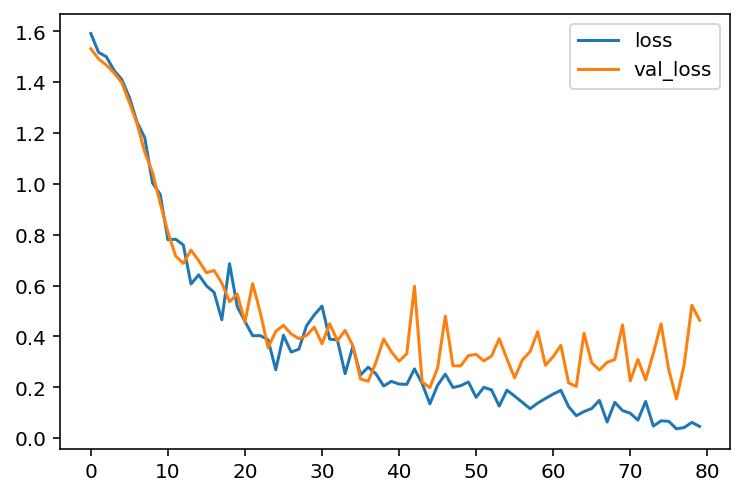

In [164]:
p3_utils.plot_history(history, ['loss', 'val_loss'])

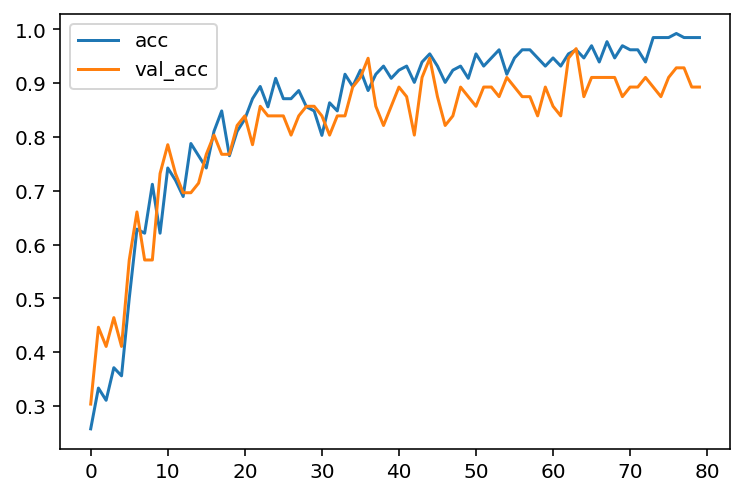

In [165]:
p3_utils.plot_history(history, ['acc', 'val_acc'])

In [166]:
emoji_model.evaluate(train_x, train_y)
emoji_model.evaluate(test_x, test_y)

56/56 [==============================] - 0s 908us/sample - loss: 0.4641 - acc: 0.8929


[0.46414500900677275, 0.89285713]

### Sava and Load Models

In [167]:
# import
import h5py

Two parts need to be saved inorder to use the model in prod:

1. Neural Network Structure
2. Trained Weights (Matrix)

We will save them separately. This makes it easy to manage multiple versions of weights and we can always choose which version to go for production.

In [168]:
import os

model_root = 'resources/emoji_model'
os.makedirs(model_root, exist_ok=True)

In [169]:
model_root

'resources/emoji_model'

In [170]:
# Save model structure as json
with open(os.path.join(model_root, "network.json"), "w") as fp:
    fp.write(emoji_model.to_json())

# Save model weights
emoji_model.save_weights(os.path.join(model_root, "weights.h5"))

Download and load a pretrained model 

In [171]:
network_path, weights_path = p3_utils.download_best_emoji_model()

data already available, skip downloading.


In [172]:
from tensorflow.keras.models import model_from_json

# Load model structure
with open(network_path, "r") as fp:
    emoji_model_best = model_from_json(fp.read())

# Load model weights
emoji_model_best.load_weights(weights_path)

In [173]:
emoji_model_best.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

In [174]:
emoji_model_best.evaluate(train_x, train_y)
emoji_model_best.evaluate(test_x, test_y)

56/56 [==============================] - 0s 962us/sample - loss: 0.2815 - acc: 0.9286


[0.2815101998192923, 0.9285714]

In [175]:
def predict_emoji(text):
    x = p3_utils.sentences_to_indices(
        np.array([text]), 
        word_to_index, 
        maxlen)
    
    probs = emoji_model_best.predict(x)
    pred = np.argmax(probs)
    
    return p3_utils.label_to_emoji(pred)

In [176]:
test = 'i do not miss you'
print(test, predict_emoji(test))

i do not miss you ❤️


In [177]:
tests = [
    "i love you", 
    "it is horrible", 
    "funny lol", 
    "lets play with a ball", 
    "food is ready", 
    "I am not pleased",
    "I am never happy",
    "i do not hate it",
    "i do not miss you",
    "i do not like it"]

for test in tests:
    print(test, predict_emoji(test))

i love you ❤️
it is horrible 😞
funny lol 😄
lets play with a ball ⚾
food is ready 🍴
I am not pleased 😞
I am never happy 😄
i do not hate it 😞
i do not miss you ❤️
i do not like it ❤️
